# Generate 90-Day Containers Spreadsheet

In [1]:
# Previous Week
file_previous_week = '2024_12_23_90DS_TC.xlsx'

# Current Week
file_current_week = '2024_01_06_90DS_TC.xlsx'

### Prepare the Notebook

In [2]:
from Notebook_Utilities import *

### Import/Clean Data

##### Historical Data (Shipments)

In [3]:
# Import BPO (ACT) Dataset
df1 = load_and_clean_data('0_CY2024_Waste_Streams_0.xlsx', 'BPO')

# Ensure the column is treated as strings/text
df1['WIWPS_ID'] = df1['WIWPS_ID'].astype(str).str.strip()
df1['WIWPS_Name'] = df1['WIWPS_Name'].astype(str).str.strip()
# Ensure the column is treated as strings/text and remove ".0"
df1['TSDF_ID'] = df1['TSDF_ID'].astype(str).str.strip().str.replace(r'\.0$', '', regex=True)
df1['ACT_ID'] = df1['ACT_ID'].astype(str).str.strip().str.replace(r'\.0$', '', regex=True)
df1['DOT_Class'] = df1['DOT_Class'].astype(str).str.strip().str.replace(r'\.0$', '', regex=True)

# Show the shape and column names
print('\ndf1 Shape:', df1.shape)


df1 Shape: (44, 12)


##### Historical Data (WIWPS_ID)

In [4]:
# Import BPO (ACT) Dataset
df0 = load_and_clean_data('0_CY2024_Waste_Streams_0.xlsx', 'WIWPS')

# Ensure the column is treated as strings/text
df0['WIWPS_ID'] = df0['WIWPS_ID'].astype(str).str.strip()
df0['WIWPS_Name'] = df0['WIWPS_Name'].astype(str).str.strip()

# Show the shape and column names
print('\ndf0 Shape:', df0.shape)


df0 Shape: (1822, 7)


##### Real-Time Data (90DS)

> - Open COS > Containers > New/Edit > Send to Excel > 90 Day Field > "90Day_data.xlsx"

In [5]:
# Import Data
df2 = load_and_clean_data('90Day_data.xlsx', 'Sheet')

# Replace Column Names
df2['WAC'].replace(["Karina Tovar", "Timothy Ryan Chomiak"], "Angel Quintero", inplace=True)

# Dictionary for clarity: Original column -> New column
column_mapping = {
    'Container': 'Container_ID',
    '90th_Day': 'ASD_90',
    'ASD': 'ASD_0',
    'Name': 'WIWPS_Name',
    'WIWPS': 'WIWPS_ID',
    'Package': 'Package_ID'
    # Add remaining mappings if necessary
}

# Rename columns using the mapping
df2.rename(columns=column_mapping, inplace=True)

# Show the shape and column names
print('\n90DS Shape:', df2.shape)

# Show Columns
df2.columns


90DS Shape: (69, 11)


Index(['Container_ID', 'ASD_90', 'ASD_0', 'Drum_Name', 'Location', 'Site_ID',
       'WAC', 'Contents', 'Parameter', 'WIWPS_ID', 'Package_ID'],
      dtype='object')

### Add Columns

##### Connecting WIWPS_ID to WIWPS_Name

In [6]:
# Connecting WIWPS to Shipping Information
def map_and_add_columns_with_multiple_matches(
    df_1, df_2, column_to_map, mapping_column, columns_to_add, match_values=None, delimiter_pattern=r"[,\s]+"
):
    """
    Matches single or multiple entries in df_2[column_to_map] against multiple entries in df_1[mapping_column],
    and pulls specific columns from df_1 into df_2 while preserving df_2's rows.

    Parameters:
        df_1 (pd.DataFrame): The source DataFrame containing rows to pull columns from.
        df_2 (pd.DataFrame): The target DataFrame where new columns will be added.
        column_to_map (str): Column in df_2 to match against df_1[mapping_column].
        mapping_column (str): Column in df_1 containing single or multiple comma-separated entries.
        columns_to_add (list): List of column names from df_1 to add to df_2.
        match_values (list, optional): A list of values in df_2[column_to_map] to match.
        delimiter_pattern (str): Regex pattern to split multiple entries in df_1.

    Returns:
        pd.DataFrame: The updated df_2 with specified columns added.
    """
    # Preprocess df_1 to split mapping_column into multiple rows for matching
    expanded_df_1 = (
        df_1.assign(Expanded_ID=df_1[mapping_column].str.split(delimiter_pattern))
        .explode("Expanded_ID")
        .dropna(subset=["Expanded_ID"])
    )
    expanded_df_1["Expanded_ID"] = expanded_df_1["Expanded_ID"].str.strip()

    # Create a mapping dictionary for each column to add
    mapping_dicts = {
        col: expanded_df_1.set_index("Expanded_ID")[col].to_dict() for col in columns_to_add
    }

    # Filter df_2 based on match_values if provided
    if match_values:
        df_2 = df_2[df_2[column_to_map].isin(match_values)]

    # Add new columns to df_2
    for col in columns_to_add:
        df_2[col] = df_2[column_to_map].map(mapping_dicts[col]).fillna("NA")

    return df_2

##### Connecting WIWPS_ID to WIWPS_Name

In [7]:
# Drop existing WIWPS_Name column in df2 if it exists
if "WIWPS_Name" in df2.columns:
    df2.drop(columns=["WIWPS_Name"], inplace=True)

# Columns to pull from df_1 and add to df_2
columns_to_add=['WIWPS_Name']

# Apply Function
df2 = map_and_add_columns_with_multiple_matches(
    df0, # Historical DataFrame                  
    df2, # New DataFrame (90DS)
    column_to_map="WIWPS_ID", # Column in df_2 to match against df_1
    mapping_column="WIWPS_ID", # Dynamic creation of mapping dictionary
    columns_to_add=columns_to_add,
    delimiter_pattern=r"[,\s]+"
)

##### Connecting WIWPS_ID to Shipping Information Columns

In [8]:
# Columns to pull from df_1 and add to df_2
columns_to_add=[
    "PO", "Waste_Type", "TSDF", "Group", 
    "Shipping_Name","TSDF_ID", "ACT_ID", 
    "DOT_Name", "DOT_Class", "EPA_Waste_Code"]

# Apply Function
df3 = map_and_add_columns_with_multiple_matches(
    df1, # Historical DataFrame                  
    df2, # New DataFrame
    column_to_map="WIWPS_ID", # Column in df_2 to match against df_1
    mapping_column="WIWPS_ID", # Dynamic creation of mapping dictionary
    columns_to_add=columns_to_add,
    delimiter_pattern=r"[,\s]+"
)

In [9]:
print('\ndf2:', df2.shape)
print('\ndf3:', df3.columns)


df2: (69, 22)

df3: Index(['Container_ID', 'ASD_90', 'ASD_0', 'Drum_Name', 'Location', 'Site_ID',
       'WAC', 'Contents', 'Parameter', 'WIWPS_ID', 'Package_ID', 'WIWPS_Name',
       'PO', 'Waste_Type', 'TSDF', 'Group', 'Shipping_Name', 'TSDF_ID',
       'ACT_ID', 'DOT_Name', 'DOT_Class', 'EPA_Waste_Code'],
      dtype='object')


##### Create additional Map to Account for Additional Waste Streams

In [10]:
def populate_missing_columns(df, match_column, match_values, fill_defaults):
    """
    Populates missing or default values for specific rows in a DataFrame based on a match condition.

    Parameters:
        df (pd.DataFrame): The target DataFrame where values will be updated.
        match_column (str): Column name in `df` to match specific values.
        match_values (list): List of values in `match_column` to apply the defaults.
        fill_defaults (dict): Dictionary where keys are column names and values are default values.

    Returns:
        pd.DataFrame: The updated DataFrame with missing columns populated for matched rows.
    """
    # Ensure all columns in fill_defaults exist in df
    for col in fill_defaults.keys():
        if col not in df.columns:
            df[col] = None  # Add column if not present
    
    # Apply default values to matched rows
    for value in match_values:
        match_condition = df[match_column] == value
        for col, default_value in fill_defaults.items():
            df.loc[match_condition, col] = default_value
    
    return df

In [11]:
# Defaults for missing columns @ WIWPS_ID = '30-07-16', 
fill_defaults = {
    'Waste_Type': 'Solid Waste',
    'TSDF': 'Landfill',
    'Group': 'Solid Waste',
    'Shipping_Name': 'Solid Waste',
    'TSDF_ID': 'TBD',
    'ACT_ID': 'NA',
    'DOT_Name': 'NA',
    'DOT_Class': 'None',
    'EPA_Waste_Code': 'NA'
}

# Apply the function to populate missing columns
df3 = populate_missing_columns(
    df=df3,
    match_column='WIWPS_ID', 
    match_values=['30-07-16', '40-04-22'],
    fill_defaults=fill_defaults # Information not found in the Mastersheet
)

##### Add Columns for Container Information 

In [12]:
# Add new empty columns (None, np.nan, '')
df3['Container_Type'] = None
df3['Container_Size'] = None
df3['Container_Qty'] = np.nan
df3['Container_Mass'] = np.nan
df3['Container_Cost'] = np.nan
df3['Manifest_ID'] = None
df3['Line_Item'] = None

##### Connecting WIWPS_ID/Container_ID to Periodic Milk Run Consolidation

> - Add a new Column, "MR"<br>
> - If WIWPS_ID or Container_ID is present, then add a "Yes" to Column ("MR") <br>
> - If WIWPS_ID or Container_ID is NOT present, then add a "No" to Column ("MR")

In [13]:
# WIWPS
Milk_Run_WIWIPS = ['20-01-24', # Ox Contaminated Debris
                   '20-01-25', # Fuel Contaminated Debris
                   '20-04-16', # Ox Contaminated Debris/ Water
                   '20-04-18', # Fuel Contaminated Debris/ Water
                   '20-19-06', # Fuel Contaminated Debris (Non-Haz)
                   '20-19-07', # Ox Contaminated Debris (Non-Haz)
                   '30-01-08', # Fuel Contaminated Debris
                   '30-01-30', # Ox Contaminated Debris
                   #'30-01-53', #
                   '40-01-08', # Fuel Contaminated Debris
                   '40-01-28', # Ox Contaminated Debris
                   '50-02-05', # Fuel Contaminated Debris
                   '50-20-01', # Fuel Contaminated Debris
                   '60-01-02', # IDW Contaminated Debris
                   '60-02-02', # IDW Contaminated Debris (SAA)
                   '80-02-08', # Ox Contaminated Debris
                   '80-02-09'  # Fuel Contaminated Debris
                  ]

# Containers
Milk_Run_Containers = [2424, # Ox Contaminated Debris
                       2425, # Fuel Contaminated Debris
                       10721, # Ox Contaminated Debris/ Water
                       10129, # Fuel Contaminated Debris/ Water
                       361, # Fuel Contaminated Debris (Non-Haz)
                       4187, # Ox Contaminated Debris (Non-Haz)
                       9327, # Fuel Contaminated Debris
                       2138, # Ox Contaminated Debris
                       #'30-01-53', #
                       4848, # Fuel Contaminated Debris
                       2139, # Ox Contaminated Debris
                       6955, # Fuel Contaminated Debris
                       2950, # Fuel Contaminated Debris
                       6320, # IDW Contaminated Debris
                       6814, # IDW Contaminated Debris (SAA)
                       67, # Ox Contaminated Debris
                       68  # Fuel Contaminated Debris
                      ]

# Define a function to map 'Container' values to 'MR'
def map_mrc(container):
    if container in Milk_Run_Containers:
        return "Yes"
    else:
        return "No"

# Apply the function to create the 'MR' column
df2['MR'] = df2['Container_ID'].apply(map_mrc)

##### Monthly Shipping Containers
- Define a function to map 'Container Number' values to the shipping package, 'Package_ID'

In [14]:
# Define a dictionary mapping container numbers to package IDs
container_to_package = {
    **dict.fromkeys([11177, 10819, 10821, 10822, 11219], "25004"), # Universal Waste
    **dict.fromkeys([9869, 10953], "25002"), # LDR 
    **dict.fromkeys([11108, 11085, 11192, 11044, 11109, 11173, 10548, 11260, 10979, 11194, 11236, 10514, 10515, 10516, 10296], "25001"), # Lab Pack 
    **dict.fromkeys([11096, 11193, 11133, 11162, 9217], "25005"), # Lab Pack
}

# Define the mapping function
def map_package(container):
    return container_to_package.get(container, "NA")

# Apply the function to create the 'Package_ID' column
df3['Package_ID'] = df3['Container_ID'].apply(map_package)

In [15]:
# Define a dictionary mapping container numbers to package IDs
container_to_tsdf = {
    **dict.fromkeys([11177, 10819, 10821, 10822, 11219], "Veolia Environmental Services"), # Universal Waste
    **dict.fromkeys([9869, 10953], "US Ecology Nevada Inc."), # LDR 
    **dict.fromkeys([11108, 11085, 11192, 11044, 11109, 11173, 10548, 11260, 10979, 11194, 11236, 10514, 10515, 10516, 10296], "Veolia ES Technical Solutions LLC."), # Lab Pack 
    **dict.fromkeys([11096, 11193, 11133, 11162, 9217], "Veolia ES Technical Solutions LLC."), # Lab Pack
}

# Define the mapping function
def map_package(container):
    return container_to_tsdf.get(container, "NA")

# Apply the function to create the 'Package_ID' column
df3['TSDF'] = df3['Container_ID'].apply(map_package)

##### Account for New Containers

In [16]:
# Load df for Previous 90DS
previous_week = load_and_clean_data(file_previous_week, 'Sheet1') # Import Data 

# Replace Column Names
previous_week['WAC'].replace(["Karina Tovar", "Timothy Ryan Chomiak"], "Angel Quintero", inplace=True)

# Dictionary for clarity: Original column -> New column
column_mapping = {
    'Container': 'Container_ID',
    '90th_Day': 'ASD_90',
    'ASD': 'ASD_0',
    'Name': 'WIWPS_Name',
    'WIWPS': 'WIWPS_ID',
    'Package': 'Package_ID'
    # Add remaining mappings if necessary
}

# Rename columns using the mapping
previous_week.rename(columns=column_mapping, inplace=True)

# Show the shape and column names
print('90DS Shape:', previous_week.shape)

90DS Shape: (70, 17)


In [17]:
# Define the unique identifier
key_column = 'Container_ID'  # Replace with the actual column name in your dataset

# Add a "New" column to indicate if a row is new
df3['New'] = df3[key_column].apply(
    lambda x: 'Yes' if x not in previous_week[key_column].values else 'No'
)

# Save the updated current week's data with the "New" column
#current_week.to_excel(file_current_week, index=False)

#print("Process complete. Updated file saved with 'New' column.")

##### Reorder Columns

In [18]:
# Reorder Columns
df3 = df3[[
    # Internal
    'WAC', 'ASD_90', 'ASD_0', 'New', 'MR', 'Container_ID', 
    'Group', 'Drum_Name', 'WIWPS_ID', 'WIWPS_Name',
    # Staging
    'Shipping_Name', 'TSDF_ID', 'ACT_ID', 'DOT_Name', 'DOT_Class', 'EPA_Waste_Code',
    'Container_Type', 'Container_Size', 'Container_Qty', 'Container_Mass', 'Container_Cost',
    'PO', 'Waste_Type', 'Package_ID', 'Manifest_ID', 'TSDF',
    # Internal
    'Location', 'Site_ID', 'Contents', 'Parameter', 'Line_Item'
          ]]

##### Format Date Columns

In [19]:
# Convert the column to datetime if not already
df3['ASD_0'] = pd.to_datetime(df3['ASD_0'], errors='coerce')
df3['ASD_90'] = pd.to_datetime(df3['ASD_90'], errors='coerce')

# Format the column to show only the date
df3['ASD_0'] = df3['ASD_0'].dt.strftime('%m/%d/%Y')  # Adjust format as needed
df3['ASD_90'] = df3['ASD_90'].dt.strftime('%m/%d/%Y')  # Adjust format as needed

##### Fill Empty Columns

In [20]:
# Fill blank cells with "NA"
df3 = df3.fillna("TBD")

##### Omit Non-Hazardous Containers with Contaminated Media

In [21]:
# Save rows where '30-07-16' appears in any cell of the column
#removed_rows = df3[df3['WIWPS_ID'].str.contains('30-07-16', na=False)] # df3[df3['WIWPS_ID'] == '30-07-16']
# Remove rows where '30-07-16' appears in any cell of the column
#df3 = df3[~df3['WIWPS_ID'].str.contains('30-07-16', na=False)] #df3 = df3[df3['WIWPS_ID'] != '30-07-16']

# Save rows where either '30-07-16' or '40-04-22' appears in any cell
removed_rows = df3[df3['WIWPS_ID'].str.contains('30-07-16|40-04-22', na=False)]

# Remove rows where either '30-07-16' or '40-04-22' appears in any cell
df3 = df3[~df3['WIWPS_ID'].str.contains('30-07-16|40-04-22', na=False)]

##### Sort Columns

In [22]:
# Sort Rows
df3 = df3.sort_values(by=['New','MR', 'ASD_0'], ascending=True)

###

### Save as Excel File

In [23]:
# Save as Excel File
df3.to_excel(file_current_week, index=False)

<br><br>

### Stats

<br><br>

##### Get Earliest 90-Day ASD

In [24]:
# Get the earliest and latest dates
earliest_row = df3.loc[df3['ASD_90'].idxmin()]
latest_row = df3.loc[df3['ASD_90'].idxmax()]

# Combine the rows into a new DataFrame
earliest_latest_rows = pd.DataFrame([earliest_row, latest_row])


##### Total Number of Containers
- Get the number of rows
- Display the number of rows

In [25]:
# Number of New Containers
df_new_columns = df3[df3['New'] == 'Yes']
# Number of Milk Run Containers
df_mr = df3[df3['MR'] == 'Yes']
# Get a dataframe for NA Columns
df3_na = df3[df3['Waste_Type'] == 'NA']

#filtered_rows = df3.loc[df3['column_name'].str.contains('partial_value', na=False)]

# Get the Total Number of Rows
n_rows = df3.shape[0]
n_rows_new = df_new_columns.shape[0]
n_rows_mr = df_mr.shape[0]
n_rows_na = df_mr.shape[0]

# Display the number of rows
print(f"{n_rows} Total Containers")
print(f"{n_rows_new} New Containers from Last Week")
print(f"{n_rows_mr} Milk Run Consolidation Containers")

49 Total Containers
7 New Containers from Last Week
1 Milk Run Consolidation Containers


##### Containers by BPO Grouping

In [26]:
# Different Waste Types in the 
df3_Waste_Type = find_unique_text_and_counts_2(df3, 'Waste_Type')
df3_Waste_Type

,Entry,Count
0,NA,28
1,Hazardous Waste (WF),10
2,Hazardous Waste (LDR),6
3,Hazardous Waste (Lab Pack),4
4,TSCA Waste,1


##### Get a dataframe for NA Columns

In [27]:
# Save as Excel File
#df3_na.to_excel('2024_01_01_90DS_NA.xlsx', index=False)

##### Containers by Waste Group

In [28]:
df3_Group = find_unique_text_and_counts_2(df3, 'Group')

In [29]:
# Internal
df3_Group = find_unique_text_and_counts_2(df3, 'Group')   # 
df3_WIWPS_ID = find_unique_text_and_counts_2(df3, 'WIWPS_ID') # 
df3_WIWPS_Name = find_unique_text_and_counts_1(df3, 'WIWPS_Name') # No Delimiter
df3_WIWPS_Name2 = find_unique_text_and_counts_2(df3, 'WIWPS_Name') # 

# Shipping
df3_TSDF_ID = find_unique_text_and_counts_2(df3, 'TSDF_ID') # 
df3_ACT_ID = find_unique_text_and_counts_2(df3, 'ACT_ID') # 
df3_Shipping_Name = find_unique_text_and_counts_1(df3, 'Shipping_Name') # No Delimiter
df3_Shipping_Name2 = find_unique_text_and_counts_2(df3, 'Shipping_Name') # 
df3_DOT_Name = find_unique_text_and_counts_1(df3, 'DOT_Name') # 
df3_DOT_Class = find_unique_text_and_counts_2(df3, 'DOT_Class') # 
df3_EPA_Waste_Code = find_unique_text_and_counts_1(df3, 'EPA_Waste_Code') # 
df3_EPA_Waste_Code2 = find_unique_text_and_counts_2(df3, 'EPA_Waste_Code') # 
df3_TSDF = find_unique_text_and_counts_2(df3, 'TSDF') # Package  ID

# Containers
df3_DOT_Name = find_unique_text_and_counts_2(df3, 'Container_Size') # 
df3_Container_Cost = find_unique_text_and_counts_2(df3, 'Container_Cost') # 
df3_Container_Qty = find_unique_text_and_counts_2(df3, 'Container_Qty') # 
df3_Container_Mass = find_unique_text_and_counts_2(df3, 'Container_Mass') # 

print(' ',len(df3_Group), ' Group')
print('',len(df3_WIWPS_ID), ' WIWPS_ID')
print(' ',len(df3_TSDF_ID), ' TSDF_ID')
print(' ',len(df3_ACT_ID), ' ACT_ID')
print()
print('',len(df3_WIWPS_Name), ' WIWPS_Name')
print('',len(df3_Shipping_Name), ' Shipping_Name')
print(' ',len(df3_DOT_Name),' DOT_Name')
print(' ',len(df3_DOT_Class),' DOT_Class')
print(' ',len(df3_EPA_Waste_Code),' EPA_Waste_Code @ find_unique_text_and_counts_1')
print('',len(df3_EPA_Waste_Code2),' EPA_Waste_Code @ find_unique_text_and_counts_2')

  6  Group
 38  WIWPS_ID
  6  TSDF_ID
  6  ACT_ID

 27  WIWPS_Name
 6  Shipping_Name
  1  DOT_Name
  3  DOT_Class
  6  EPA_Waste_Code @ find_unique_text_and_counts_1
 17  EPA_Waste_Code @ find_unique_text_and_counts_2


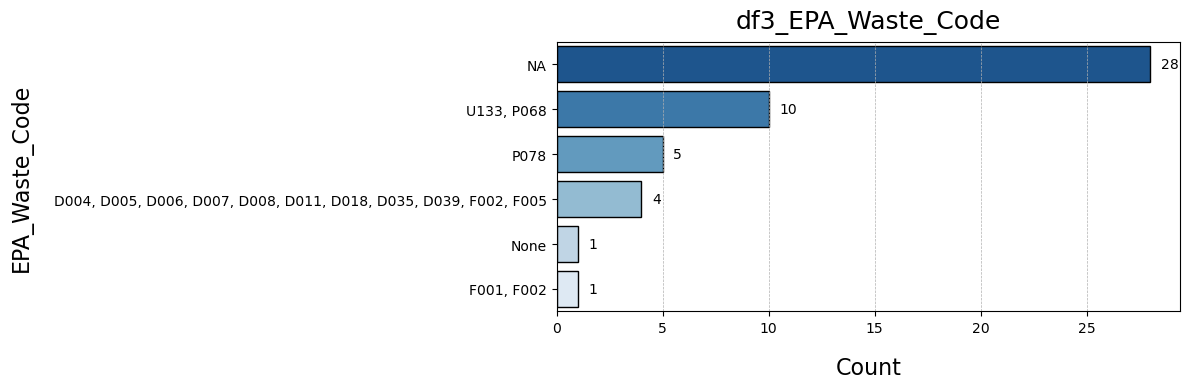

In [30]:
# Plot Results
plot_horizontal_bar(df3_EPA_Waste_Code,
                    'df3_EPA_Waste_Code', 
                    y_label='EPA_Waste_Code', 
                    figsize=(12,4), 
                    save_folder=None, 
                    file_name=None,
                    display_plot=True)

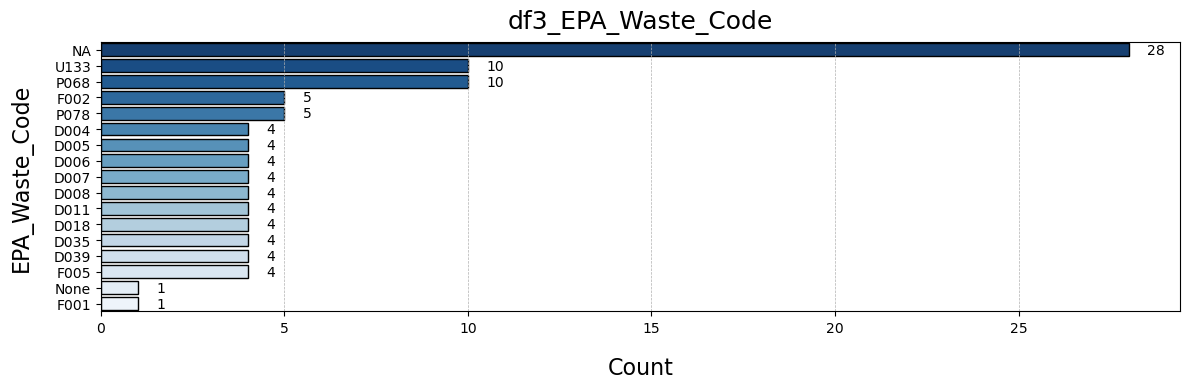

In [31]:
# Plot Results
plot_horizontal_bar(df3_EPA_Waste_Code2,
                    'df3_EPA_Waste_Code', 
                    y_label='EPA_Waste_Code', 
                    figsize=(12,4), 
                    save_folder=None, 
                    file_name=None,
                    display_plot=True)

In [32]:
# Identify rows with missing ID_2 values
#missing_mask = df_hw['ACT_ID'].isna()  # Boolean mask for missing values
#missing_rows = df_hw[missing_mask]  # Extract rows with missing ID_2

In [33]:
halt

NameError: name 'halt' is not defined

### Email Automation

##### Recipients

In [ ]:
# List of recipients 
# Store recipients in a CSV file or database for dynamic updates.
recipients = ["recipient1@gmail.com", 
              "recipient2@gmail.com", 
              "recipient3@gmail.com"]

##### Subject and Content

In [ ]:
# Subject and content for the email
subject = "Automated Statistics Report"
plain_text_content = f"""

Hello,

Here are the key statistics from the analysis:
- Total: {total}
- Average: {average}
- Max: {max_value}
- Min: {min_value}

Best regards,
Your Automation Script
"""

##### HTML Code

In [ ]:
# HTML Code
html_content = f"""
<html>
    <body>
        <h3>Key Statistics:</h3>
        <ul>
            <li><b>Total:</b> {total}</li>
            <li><b>Average:</b> {average}</li>
            <li><b>Max:</b> {max_value}</li>
            <li><b>Min:</b> {min_value}</li>
        </ul>
        <p>Automated by your Python script!</p>
    </body>
</html>
"""

##### Send email to each recipient

In [ ]:
# Send email to each recipient
for recipient in recipients:
    send_email(sender_email, recipient, password, 
               smtp_server, smtp_port, subject, 
               plain_text_content, html_content)

Use Environment Variables for Security

In [ ]:
Track Email Delivery

In [ ]:
import logging
logging.basicConfig(filename="email_log.txt", level=logging.INFO)

### Automate Execution (Optional)

In [ ]:
# Step 5: Automate Execution (Optional)
# Convert this notebook to a script for automation.
# Use nbconvert to create a Python script version of this notebook.

# Run this command in the terminal or as a cell magic
#!jupyter nbconvert --to script your_notebook_name.ipynb

# The output file will be your_notebook_name.py
# Use Task Scheduler (Windows) or Cron (Linux/Mac) to run the script periodically.